# Model 1 using MLP Neural Network

In [1]:
# Name: Anthony Tan Beng Wah   NRIC: 095C
# Import the requried packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import requests
import os
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model, neighbors, tree, svm, ensemble, neural_network
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate

In [2]:
# Data Retrieval from Database
# URL of the SQLite database
url = "https://techassessment.blob.core.windows.net/aiap19-assessment-data/agri.db"
file_name = "agri.db"

# Download the file from the URL
if not os.path.exists(file_name):  # Check if the file is already downloaded
    print(f"Downloading {file_name}...")
    response = requests.get(url)
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print("Download complete.")

# Connect to the SQLite database
conn = sqlite3.connect(file_name)

# List tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, conn)
print("Tables in the database:")
print(tables)

# Read data from farm_data table and load into agri dataframe
table_name = "farm_data"  # Replace with the table name you want to query
agri = pd.read_sql_query(f"SELECT * FROM {"farm_data"};", conn)

# Display the data
print(agri.head())

Tables in the database:
        name
0  farm_data
  System Location Code Previous Cycle Plant Type           Plant Type  \
0               Zone_D                     Herbs           Vine Crops   
1               Zone_G                     Herbs           VINE CROPS   
2               Zone_F                     Herbs                herbs   
3               Zone_G                     Herbs  fruiting vegetables   
4               Zone_B                Vine Crops         LEAFY GREENS   

  Plant Stage  Temperature Sensor (°C)  Humidity Sensor (%)  \
0    Maturity                    23.34                  NaN   
1  Vegetative                   -24.16                63.14   
2    maturity                    23.84                  NaN   
3  Vegetative                    22.61                  NaN   
4    seedling                    22.88                  NaN   

   Light Intensity Sensor (lux)  CO2 Sensor (ppm)  EC Sensor (dS/m)  \
0                         454.0               937            

In [3]:
# display the datatype of agri db attributes
agri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

In [4]:
agri = agri.drop(columns=['System Location Code'])   # This column is not necessary and can be dropped

In [5]:
# check for columns with null value
agri.isnull().sum()

Previous Cycle Plant Type           0
Plant Type                          0
Plant Stage                         0
Temperature Sensor (°C)          8689
Humidity Sensor (%)             38867
Light Intensity Sensor (lux)     4278
CO2 Sensor (ppm)                    0
EC Sensor (dS/m)                    0
O2 Sensor (ppm)                     0
Nutrient N Sensor (ppm)          9974
Nutrient P Sensor (ppm)          5698
Nutrient K Sensor (ppm)          3701
pH Sensor                           0
Water Level Sensor (mm)          8642
dtype: int64

In [6]:
# Data Cleansing
# Remove 'ppm' from the nutrient_n, nutrient_p and nutrient_k columns and then convert these 3 columns to float data type
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].astype(float)
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].astype(float)
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].str.replace('ppm', '', regex=False).str.strip()
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].astype(float)


# Replace NaN values with the median value of the column
agri['Nutrient N Sensor (ppm)'] = agri['Nutrient N Sensor (ppm)'].fillna(agri['Nutrient N Sensor (ppm)'].median())
agri['Nutrient P Sensor (ppm)'] = agri['Nutrient P Sensor (ppm)'].fillna(agri['Nutrient P Sensor (ppm)'].median())
agri['Nutrient K Sensor (ppm)'] = agri['Nutrient K Sensor (ppm)'].fillna(agri['Nutrient K Sensor (ppm)'].median())
agri['Temperature Sensor (°C)'] = agri['Temperature Sensor (°C)'].fillna(agri['Temperature Sensor (°C)'].median())
agri['Humidity Sensor (%)'] = agri['Humidity Sensor (%)'].fillna(agri['Humidity Sensor (%)'].median())
agri['Light Intensity Sensor (lux)'] = agri['Light Intensity Sensor (lux)'].fillna(agri['Light Intensity Sensor (lux)'].median())
agri['Water Level Sensor (mm)'] = agri['Water Level Sensor (mm)'].fillna(agri['Water Level Sensor (mm)'].median())

agri.head(20)

,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Herbs,Vine Crops,Maturity,23.34,68.70,454.0,937,1.82,4,161.0,64.0,201.0,6.1,28.150346
1,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161.0,53.0,215.0,6.5,31.000000
2,Herbs,herbs,maturity,23.84,68.70,562.0,1246,1.21,8,228.0,79.0,292.0,6.4,26.000000
3,Herbs,fruiting vegetables,Vegetative,22.61,68.70,651.0,1346,1.96,6,158.0,53.0,289.0,6.6,26.000000
4,Vine Crops,LEAFY GREENS,seedling,22.88,68.70,144.0,812,2.76,5,61.0,19.0,168.0,5.5,28.000000
5,Vine Crops,FRUITING VEGETABLES,MATURITY,25.96,68.70,675.0,1338,1.75,8,227.0,53.0,258.0,6.2,23.092135
6,Leafy Greens,Vine Crops,Maturity,23.21,68.70,514.0,1103,1.14,8,174.0,62.0,217.0,5.5,35.000000
7,Herbs,Leafy Greens,Maturity,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156
8,Herbs,Leafy Greens,Maturity,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156
9,Vine Crops,Vine Crops,MATURITY,25.59,68.70,435.0,845,2.07,8,150.0,70.0,210.0,5.3,27.835062


In [7]:
agri.isnull().sum()  # check to confirm no more null value

Previous Cycle Plant Type       0
Plant Type                      0
Plant Stage                     0
Temperature Sensor (°C)         0
Humidity Sensor (%)             0
Light Intensity Sensor (lux)    0
CO2 Sensor (ppm)                0
EC Sensor (dS/m)                0
O2 Sensor (ppm)                 0
Nutrient N Sensor (ppm)         0
Nutrient P Sensor (ppm)         0
Nutrient K Sensor (ppm)         0
pH Sensor                       0
Water Level Sensor (mm)         0
dtype: int64

In [8]:
# Column values to convert to lowercase for Plant Type and Plant Stage for consistency in data analytics and predictions
agri['Plant Type'] = agri['Plant Type'].str.lower()
agri['Plant Stage'] = agri['Plant Stage'].str.lower()

In [9]:
# Concatenate Plant Type and Plant Stage and then add the new column into dataframe.  Next, drop the individual Plant Type and Plant Stage columns.
agri['Plant Info'] = agri['Plant Type'] + ' - ' + agri['Plant Stage']
agri = agri.drop(columns=['Plant Type', 'Plant Stage'])
agri.head(20)

,Previous Cycle Plant Type,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Plant Info
0,Herbs,23.34,68.70,454.0,937,1.82,4,161.0,64.0,201.0,6.1,28.150346,vine crops - maturity
1,Herbs,-24.16,63.14,441.0,938,2.13,6,161.0,53.0,215.0,6.5,31.000000,vine crops - vegetative
2,Herbs,23.84,68.70,562.0,1246,1.21,8,228.0,79.0,292.0,6.4,26.000000,herbs - maturity
3,Herbs,22.61,68.70,651.0,1346,1.96,6,158.0,53.0,289.0,6.6,26.000000,fruiting vegetables - vegetative
4,Vine Crops,22.88,68.70,144.0,812,2.76,5,61.0,19.0,168.0,5.5,28.000000,leafy greens - seedling
5,Vine Crops,25.96,68.70,675.0,1338,1.75,8,227.0,53.0,258.0,6.2,23.092135,fruiting vegetables - maturity
6,Leafy Greens,23.21,68.70,514.0,1103,1.14,8,174.0,62.0,217.0,5.5,35.000000,vine crops - maturity
7,Herbs,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156,leafy greens - maturity
8,Herbs,20.16,68.70,317.0,1133,1.52,10,158.0,50.0,277.0,5.8,39.611156,leafy greens - maturity
9,Vine Crops,25.59,68.70,435.0,845,2.07,8,150.0,70.0,210.0,5.3,27.835062,vine crops - maturity


In [10]:
# Set the "temperature" as target/model output and the rest features as model inputs
y = agri['Temperature Sensor (°C)']
X = agri.drop(['Temperature Sensor (°C)'], axis=1)

In [11]:
# Split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Scale down the numerical data (Not Required) and encode the categorical data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

num_attribs = list(X.select_dtypes(['int64', 'float64']))
cat_attribs = list(X.select_dtypes(['object']))

# Ensure all categorical columns have uniform string types
X_train1[cat_attribs] = X_train1[cat_attribs].astype(str)
X_test1[cat_attribs] = X_test1[cat_attribs].astype(str)

scaler = StandardScaler()
encoder = OrdinalEncoder()

X_train = X_train1.copy()
X_train[num_attribs] = scaler.fit_transform(X_train1[num_attribs])
X_train[cat_attribs] = encoder.fit_transform(X_train1[cat_attribs])

X_test = X_test1.copy()
X_test[num_attribs] = scaler.transform(X_test1[num_attribs])
X_test[cat_attribs] = encoder.transform(X_test1[cat_attribs])

In [12]:
# Create the mlp (Neural Network) model
mlp_reg = neural_network.MLPRegressor(activation ='relu', hidden_layer_sizes=(10,),
                    max_iter= 2000, solver = 'adam')
# Fit the model to the training set
mlp_reg.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(10,), max_iter=2000)

In [13]:
# show the mean absolute error
print('train_mae: ', mean_absolute_error(mlp_reg.predict(X_train), y_train ),
'\n test_mae: ', mean_absolute_error(mlp_reg.predict(X_test), y_test))

train_mae:  2.1108677923165837 
 test_mae:  2.0873154044900404


In [14]:
# show the score
print('train_reg:', mlp_reg.score(X_train, y_train),
      '\n test_reg:', mlp_reg.score(X_test, y_test))

train_reg: 0.015575558004398582 
 test_reg: 0.010581747668251151


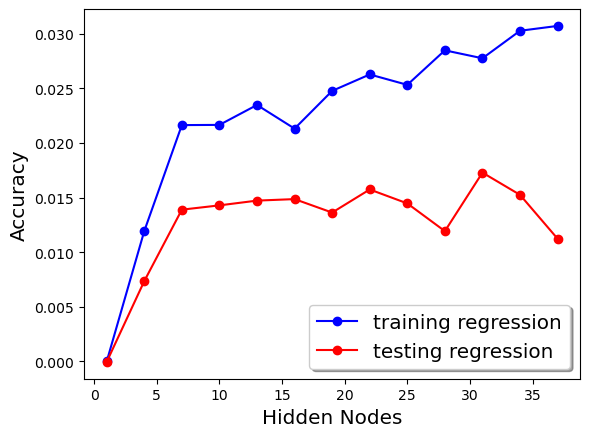

In [15]:
# Find the best # of hidden nodes
hidden_range = range(1,40,3)

train_regression = []
test_regression = []

for h in hidden_range:
    mlp_reg = neural_network.MLPRegressor(activation ='relu', hidden_layer_sizes=(h,),
                    max_iter= 2000, solver = 'adam')
    mlp_reg.fit(X_train, y_train)
    train_regression.append(mlp_reg.score(X_train, y_train))
    test_regression.append(mlp_reg.score(X_test, y_test))

#Plot the train & test accuracy
plt.plot(hidden_range, train_regression, 'bo-', label ='training regression')
plt.plot(hidden_range, test_regression, 'ro-', label = 'testing regression')

plt.xlabel('Hidden Nodes', fontsize='x-large')
plt.ylabel('Accuracy', fontsize='x-large')

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.show()

In [22]:
# Final mlp model
mlp_reg = neural_network.MLPRegressor(activation ='relu', hidden_layer_sizes=(31,),
                    max_iter= 2000, solver = 'adam')
mlp_reg.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(31,), max_iter=2000)

In [23]:
print('train_mae: ', mean_absolute_error(mlp_reg.predict(X_train), y_train ),
'\n test_mae: ', mean_absolute_error(mlp_reg.predict(X_test), y_test))

train_mae:  2.414790246700264 
 test_mae:  2.4028941014320466


In [24]:
print('train_reg:', mlp_reg.score(X_train, y_train),
      '\n test_reg:', mlp_reg.score(X_test, y_test))

train_reg: 0.02551537585582253 
 test_reg: 0.014662943631445047


In [25]:
mlp_reg.score(X_test, y_test)

0.014662943631445047

In [26]:
test_data = X_test1[0:10]    # Pick 10 rows of test data to show predicted temperatures
test_data

,Previous Cycle Plant Type,Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Plant Info
23661,Herbs,77.09,560.0,959,1.92,6,172.0,60.0,200.0,5.7,34.959373,vine crops - maturity
44355,Leafy Greens,68.70,317.0,1015,2.01,6,158.0,70.0,317.0,7.0,33.000000,herbs - maturity
22013,Herbs,68.70,-235.0,911,1.28,6,112.0,33.0,134.0,6.2,27.000000,vine crops - seedling
42242,Leafy Greens,68.70,379.0,1028,1.62,6,153.0,37.0,237.0,6.8,34.000000,leafy greens - vegetative
49698,Herbs,73.51,230.0,952,2.04,5,138.0,47.0,215.0,5.8,23.000000,vine crops - seedling
44139,Leafy Greens,68.70,560.0,881,1.79,10,186.0,69.0,215.0,5.6,30.000000,vine crops - maturity
4129,Leafy Greens,62.90,231.0,1028,1.07,6,139.0,50.0,288.0,5.4,24.000000,leafy greens - vegetative
11695,Fruiting Vegetables,68.70,177.0,914,1.12,5,158.0,29.0,186.0,5.8,20.000000,leafy greens - seedling
47315,Vine Crops,68.70,491.0,1396,1.63,8,221.0,61.0,317.0,6.1,20.000000,herbs - vegetative
48254,Leafy Greens,68.70,223.0,813,1.40,6,170.0,42.0,228.0,6.4,29.000000,leafy greens - maturity


In [27]:
predicted_temp = y_test[0:10]  # Predicted Temperatures
predicted_temp

23661    26.00
44355    23.26
22013    22.80
42242    21.56
49698    23.18
44139    23.21
4129     23.21
11695    23.21
47315    23.68
48254    20.63
Name: Temperature Sensor (°C), dtype: float64

In [28]:
# Build a Machine Learning Pipeline for Model 1 MLP

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_attribs = list(X.select_dtypes(['int64','float64']))
cat_attribs = list(X.select_dtypes(['object']))

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [29]:
# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attribs),
    ('num', num_pipe, num_attribs)
])

In [30]:
# Fit a pipeline with transformers and an estimator to the training data

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', neural_network.MLPRegressor(activation ='relu', hidden_layer_sizes=(31,),
                    max_iter= 2000, solver = 'adam')),
])

In [31]:
# Train the pipeline and evaluate the pipeline performance
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Previous Cycle Plant Type',
                                                   'Plant Info']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity Sensor (%)',
                                                   'Light Intensity Sensor '
                                                   '(lux)',
                                                   'CO2 Sensor (ppm)',
                                                   'EC Sensor (dS/m)',
                                                   'O2 Sensor (ppm)',
                                                   'Nutrient N Sensor (ppm)',
                                                   'Nutrient P Sensor (ppm)',
                                                   'Nutrient K Sensor (ppm)',
                                                   'pH Sensor',
                                                   'Water Level Sensor '
                                                   '(mm)'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=(31,), max_iter=2000))])

In [32]:
# Save the pipeline model
import joblib
joblib.dump(pipe, "pipe_model1_mlp.pkl")

['pipe_model1_mlp.pkl']

In [36]:
# Test the model 1 mlp pipeline with 5 rows of Test Data
some_data = X_test[0:5]
some_data

,Previous Cycle Plant Type,Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm),Plant Info
23661,1.0,2.509702,0.755827,-0.720773,0.716037,-0.506467,0.343822,0.693901,-0.301080,-0.803830,1.721003,9.0
44355,2.0,-0.054071,-0.375956,-0.395308,0.932870,-0.506467,0.006817,1.377084,1.693979,2.454250,1.354426,3.0
22013,1.0,-0.054071,-2.946922,-0.999743,-0.825884,-0.506467,-1.100483,-1.150694,-1.426498,0.449278,0.231892,10.0
42242,2.0,-0.054071,-0.087188,-0.319754,-0.006738,-0.506467,-0.113541,-0.877420,0.329836,1.953007,1.541515,8.0
49698,1.0,1.415744,-0.781163,-0.761456,1.005148,-1.380104,-0.474618,-0.194237,-0.045303,-0.553208,-0.516463,10.0


In [37]:
my_pipeline_loaded = joblib.load("pipe_model1_mlp.pkl")
my_pipeline_loaded.predict(some_data)

array([22.48701535, 22.74569731, 22.38890135, 20.81032297, 22.03367633])